In [1]:
import os
import stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


<body/>**Data Fields
Data fields
Most of the fields are self-explanatory. The following are descriptions for those that
aren't.

<body/>**
Id - an Id that represents a (Store, Date) duple within the test set
Store - a unique Id for each store
    
Sales - the turnover for any given day (this is what you are predicting)
Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are
closed on state holidays

 Note that all schools are closed on public holidays and
weekend
. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public
schools
StoreType - differentiates between 4 different store models: a, b,
 c, d
Assortment - describes an assortment level: a = basic, b = extra, c = extended. Read
more about assortme
nt here
CompetitionDistance - distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the
time the nearest competitor was opened
Promo - indicates whether a store is running a promo on that day
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 =
store is not participating, 1 = store is participating
Promo2Since[Year/Week] - describes the year and calendar week when the store
started participating in Promo2
PromoInterval - describes the consecutive intervals Promo2 is started, naming the
months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round
starts in February, May, August, November of any given y<body></body>ear for that store

<body/>**Task 1 - Exploration of customer purchasing behaviour<body>

In [2]:
train_data =pd.read_csv("train.csv")
test_data =pd.read_csv("test.csv")
store_data=pd.read_csv("store.csv")
sample_data=pd.read_csv("sample_submission.csv")

In [3]:
train_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
train_data.shape

(1017209, 9)

In [5]:
train_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [6]:
train_data.duplicated().sum()

0

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0


# Checking outliers on train_data

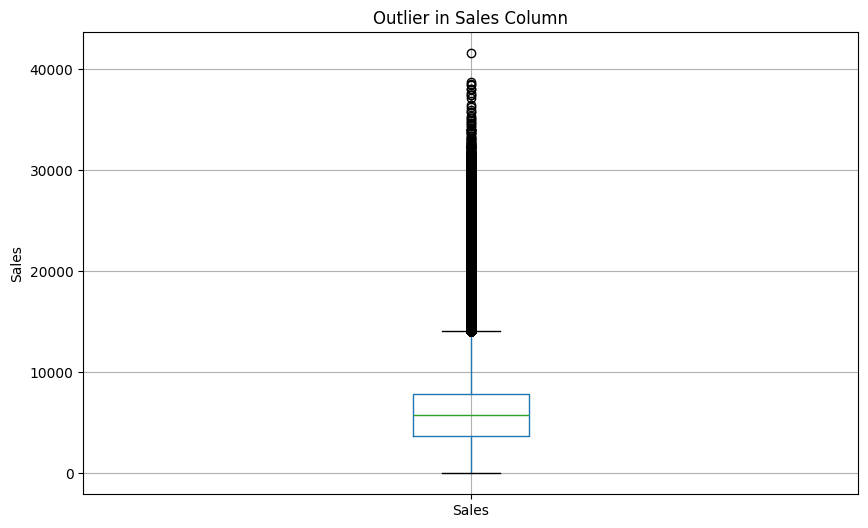

In [9]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
train_data.boxplot(column='Sales')
plt.title('Outlier in Sales Column')
plt.ylabel('Sales')
plt.show()

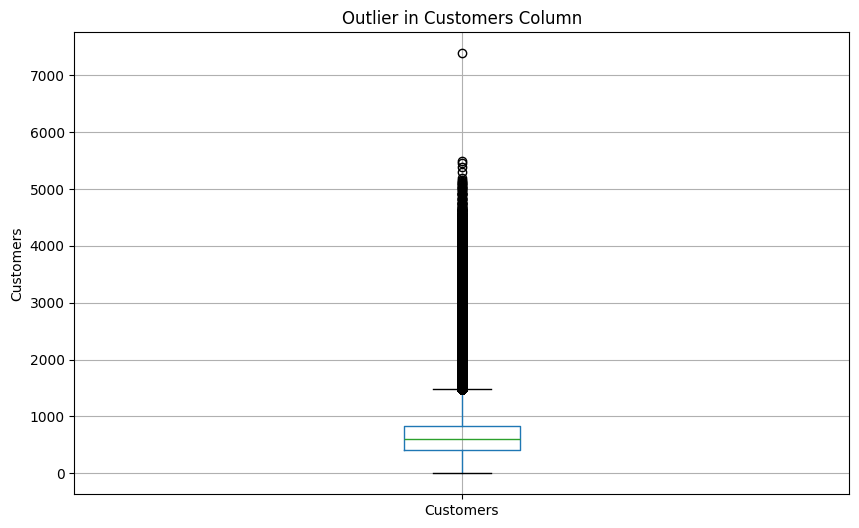

In [10]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
train_data.boxplot(column='Customers')
plt.title('Outlier in Customers Column')
plt.ylabel('Customers')
plt.show()

# Remove Outliers

In [11]:
def iqr_technique(DFcolumn):
  Q1 = np.percentile(DFcolumn, 25)
  Q3 = np.percentile(DFcolumn, 75)
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)                        

  return lower_range,upper_range

In [12]:
lower_bound,upper_bound = iqr_technique(train_data['Customers'])

train_data = train_data[(train_data.Customers>lower_bound) & (train_data.Customers<upper_bound)]

In [13]:
lower_bound,upper_bound = iqr_technique(train_data['Sales'])

train_data = train_data[(train_data.Sales>lower_bound) & (train_data.Sales<upper_bound)]

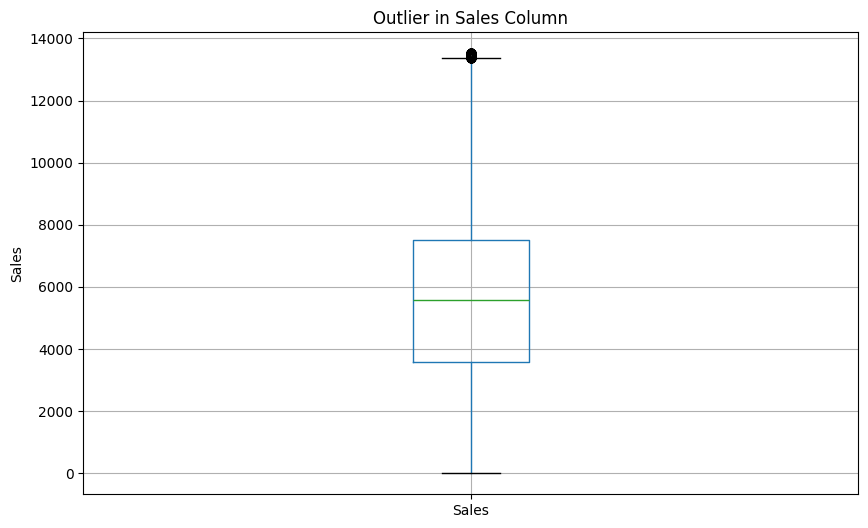

In [14]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
train_data.boxplot(column='Sales')
plt.title('Outlier in Sales Column')
plt.ylabel('Sales')
plt.show()

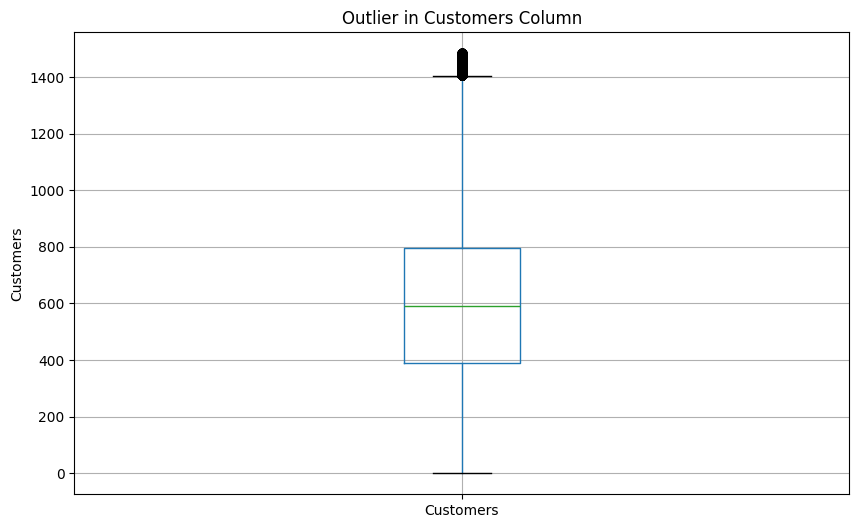

In [15]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
train_data.boxplot(column='Customers')
plt.title('Outlier in Customers Column')
plt.ylabel('Customers')
plt.show()

In [16]:
train_data.shape

(968510, 9)

#  Working On Test_data

In [17]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [18]:
test_data.shape

(41088, 8)

In [19]:
test_data.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [20]:
test_data.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [22]:
test_data = test_data.fillna({'Open': 0})

In [23]:
test_data.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [25]:
test_data.duplicated().sum()

0

# Working with Store Data

In [11]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
store_data.shape

(1115, 10)

In [26]:
store_data.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [27]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [28]:
#  Filling numerical missing values with median
numerical_cols = store_data.select_dtypes(include=['float64', 'int64']).columns
store_data[numerical_cols] = store_data[numerical_cols].apply(lambda x: x.fillna(x.median()), axis=0)

In [29]:
# Filling categorical missing values with 'Unknown'
categorical_cols = store_data.select_dtypes(include=['object']).columns
store_data[categorical_cols] = store_data[categorical_cols].apply(lambda x: x.fillna('Unknown'))

In [30]:
store_data.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

# checking outliers on store_data

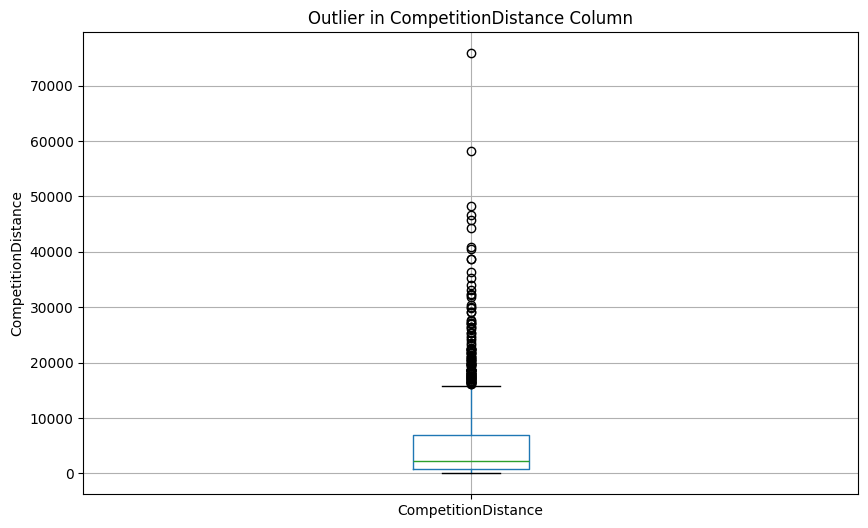

In [31]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
store_data.boxplot(column='CompetitionDistance')
plt.title('Outlier in CompetitionDistance Column')
plt.ylabel('CompetitionDistance')
plt.show()

# Removing Outliers

In [32]:
lower_bound,upper_bound = iqr_technique(store_data['CompetitionDistance'])

store_data = store_data[(store_data.CompetitionDistance>lower_bound) & (store_data.CompetitionDistance<upper_bound)]

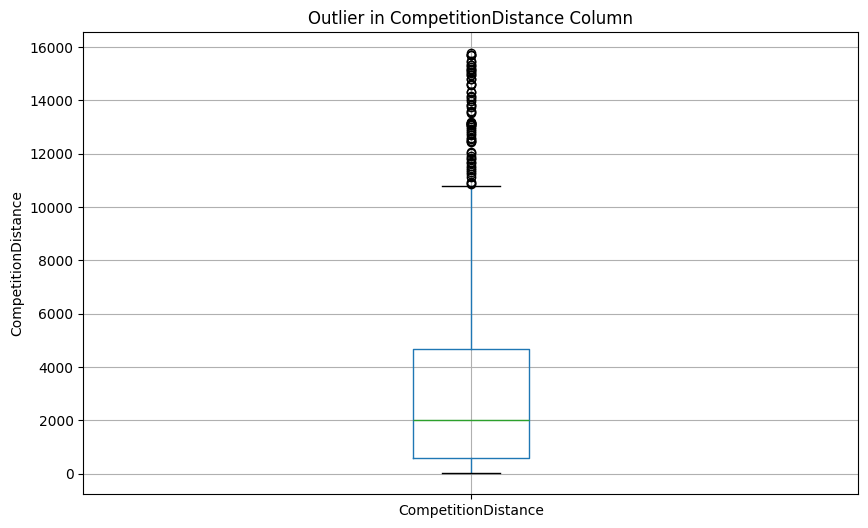

In [33]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
store_data.boxplot(column='CompetitionDistance')
plt.title('Outlier in CompetitionDistance Column')
plt.ylabel('CompetitionDistance')
plt.show()

In [34]:
store_data.shape

(1007, 10)

# Working on Sample_Submission_data

In [13]:
sample_data.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [15]:
sample_data.shape

(41088, 2)

In [35]:
sample_data.columns

Index(['Id', 'Sales'], dtype='object')

# Data Preprocessing

In [36]:
train_data["Date"]=pd.to_datetime(train_data["Date"])
test_data["Date"]=pd.to_datetime(test_data["Date"])

In [37]:
#find the date part of the Datetime Index object.
def holiday(x):
    if x in ['a','b','c']:
        return 1
    return 0
    
def day_month_year(df, col):
    try:
        df['Day'] = pd.DatetimeIndex(df[col]).day
        df['Month'] = pd.DatetimeIndex(df[col]).month
        df['Year'] = pd.DatetimeIndex(df[col]).year
    except KeyError:
        print("Unknown Column Index")
    
train_data['Holiday'] = train_data['StateHoliday'].apply(holiday)
test_data['Holiday'] = test_data['StateHoliday'].apply(holiday)
train_data['Holiday'] = train_data['Holiday'] | train_data['SchoolHoliday']
test_data['Holiday'] = test_data['Holiday'] | test_data['SchoolHoliday']
day_month_year(train_data, 'Date') 
day_month_year(test_data, 'Date')

In [38]:
test_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Id,41088.0,20544.5,1.0,10272.75,20544.5,30816.25,41088.0,11861.228267
Store,41088.0,555.899533,1.0,279.75,553.5,832.25,1115.0,320.274496
DayOfWeek,41088.0,3.979167,1.0,2.0,4.0,6.0,7.0,2.015481
Date,41088,2015-08-24 12:00:00,2015-08-01 00:00:00,2015-08-12 18:00:00,2015-08-24 12:00:00,2015-09-05 06:00:00,2015-09-17 00:00:00,NaN
Open,41088.0,0.854094,0.0,1.0,1.0,1.0,1.0,0.353017
Promo,41088.0,0.395833,0.0,0.0,0.0,1.0,1.0,0.489035
SchoolHoliday,41088.0,0.443487,0.0,0.0,0.0,1.0,1.0,0.496802
Holiday,41088.0,0.447868,0.0,0.0,0.0,1.0,1.0,0.497281
Day,41088.0,13.520833,1.0,6.75,12.5,19.25,31.0,8.44845
Month,41088.0,8.354167,8.0,8.0,8.0,9.0,9.0,0.478266


In [39]:
test_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Id,41088.0,20544.5,1.0,10272.75,20544.5,30816.25,41088.0,11861.228267
Store,41088.0,555.899533,1.0,279.75,553.5,832.25,1115.0,320.274496
DayOfWeek,41088.0,3.979167,1.0,2.0,4.0,6.0,7.0,2.015481
Date,41088,2015-08-24 12:00:00,2015-08-01 00:00:00,2015-08-12 18:00:00,2015-08-24 12:00:00,2015-09-05 06:00:00,2015-09-17 00:00:00,NaN
Open,41088.0,0.854094,0.0,1.0,1.0,1.0,1.0,0.353017
Promo,41088.0,0.395833,0.0,0.0,0.0,1.0,1.0,0.489035
SchoolHoliday,41088.0,0.443487,0.0,0.0,0.0,1.0,1.0,0.496802
Holiday,41088.0,0.447868,0.0,0.0,0.0,1.0,1.0,0.497281
Day,41088.0,13.520833,1.0,6.75,12.5,19.25,31.0,8.44845
Month,41088.0,8.354167,8.0,8.0,8.0,9.0,9.0,0.478266


# Merging 'train.csv' and 'store.csv'
#Both dataset have common column 'store'

#We use that column to merge store into train dataset

In [40]:
train_store_data = pd.merge(train_data, store_data, how = 'inner', on = 'Store')

In [41]:
train_store_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Holiday,...,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,1,...,2015,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,Unknown
1,2,5,2015-07-31,6064,625,1,1,0,1,1,...,2015,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,1,...,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,6,5,2015-07-31,5651,589,1,1,0,1,1,...,2015,a,a,310.0,12.0,2013.0,0,22.0,2012.0,Unknown
4,8,5,2015-07-31,8492,833,1,1,0,1,1,...,2015,a,a,7520.0,10.0,2014.0,0,22.0,2012.0,Unknown


In [42]:
train_store_data.shape

(872013, 22)

# Merging 'test.csv' and 'store.csv'

In [45]:
test_store_data = pd.merge(test_data, store_data, how = 'inner', on = 'Store')

In [46]:
test_store_data.shape

(37776, 21)

In [47]:
test_store_data.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Holiday,Day,...,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,0,17,...,2015,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,Unknown
1,2,3,4,2015-09-17,1.0,1,0,0,0,17,...,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,4,8,4,2015-09-17,1.0,1,0,0,0,17,...,2015,a,a,7520.0,10.0,2014.0,0,22.0,2012.0,Unknown
3,5,9,4,2015-09-17,1.0,1,0,0,0,17,...,2015,a,c,2030.0,8.0,2000.0,0,22.0,2012.0,Unknown
4,6,10,4,2015-09-17,1.0,1,0,0,0,17,...,2015,a,a,3160.0,9.0,2009.0,0,22.0,2012.0,Unknown


# Reading the description report
Sales
The minimum sale is 0

The maximum sale is 41551.00

25% of sale is below 3727.000

50% of sale is below 5744.000

75% of sale is below 7856.000

Customers
The minimum customer is 0

The maximum customer is 7388

25% of customer is below 405

50% of customer is below 609

75% of customer is below 837


# Exploratory Data Analysis (EDA)
1.1- Distribution of Promotions in Training and Test Sets

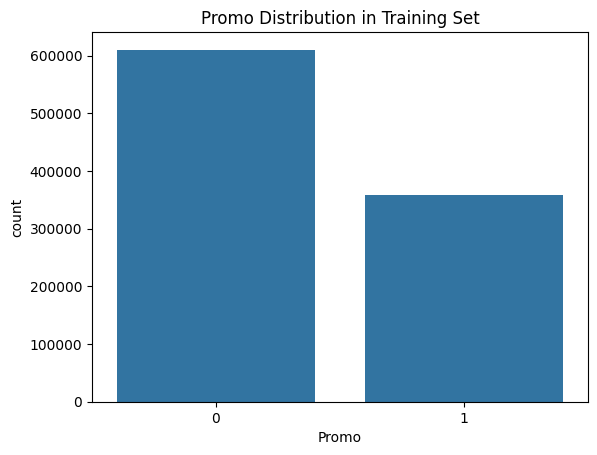

In [48]:
sns.countplot(x='Promo', data=train_data)
plt.title('Promo Distribution in Training Set')
plt.show()

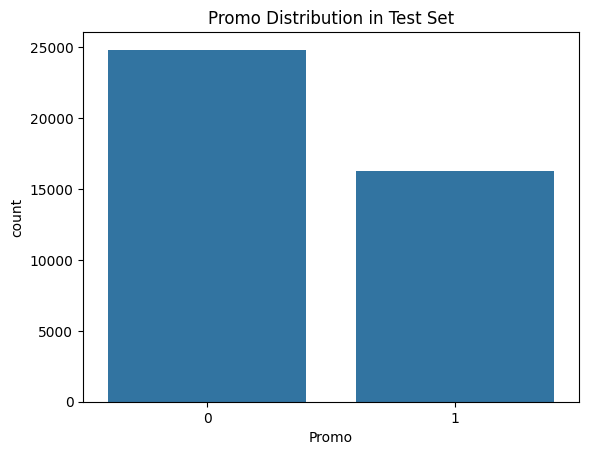

In [49]:
sns.countplot(x='Promo', data=test_data)
plt.title('Promo Distribution in Test Set')
plt.show()


# 1.2- Sales Behavior Before, During, and After Holidays
Create a feature to indicate whether the day is during holiday

In [50]:
train_store_data['HolidayPeriod'] = 'Regular'
train_store_data.loc[train_store_data['StateHoliday'] != '0', 'HolidayPeriod'] = 'During Holiday'

# Create a feature to indicate whether the day is after holiday

In [51]:
train_store_data.loc[(train_store_data['StateHoliday'] == '0') & 
                     (train_store_data['Date'].dt.dayofweek == 0) & 
                     (train_store_data['Date'].shift(1).dt.dayofweek == 6), 'HolidayPeriod'] = 'After Holiday'

# Create a feature to indicate whether the day is before holiday

In [52]:
train_store_data.loc[(train_store_data['StateHoliday'] == '0') & 
                     (train_store_data['Date'].dt.dayofweek == 6) & 
                     (train_store_data['Date'].shift(-1).dt.dayofweek == 0), 'HolidayPeriod'] = 'Before Holiday'

# Plot sales behavior during different holiday periods

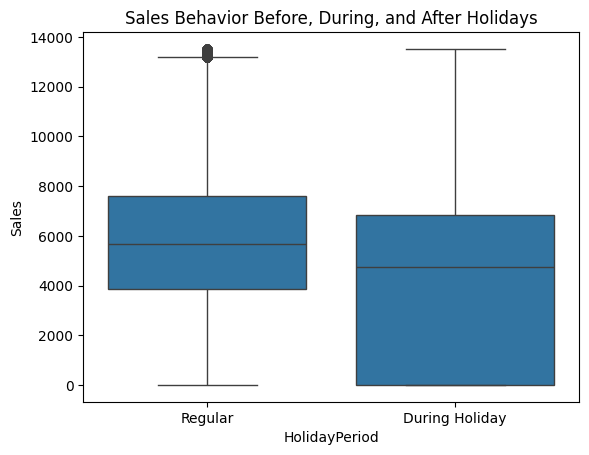

In [53]:
sns.boxplot(x='HolidayPeriod', y='Sales', data=train_store_data)
plt.title('Sales Behavior Before, During, and After Holidays')
plt.show()

# Seasonal Purchase Behaviors (Christmas, Easter, etc.)

In [54]:
# Extract month and day for easier seasonal analysis
train_store_data['Month'] = train_store_data['Date'].dt.month
train_store_data['Day'] = train_store_data['Date'].dt.day

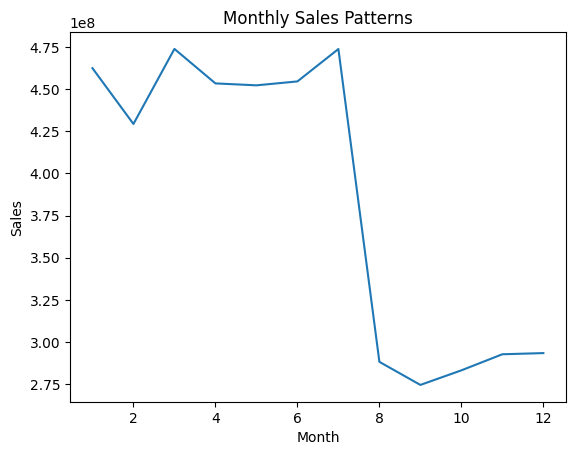

In [55]:
# Plot sales by month to identify seasonal patterns
monthly_sales = train_store_data.groupby('Month')['Sales'].sum().reset_index()
sns.lineplot(x='Month', y='Sales', data=monthly_sales)
plt.title('Monthly Sales Patterns')
plt.show()

# Correlation Between Sales and Number of Customers

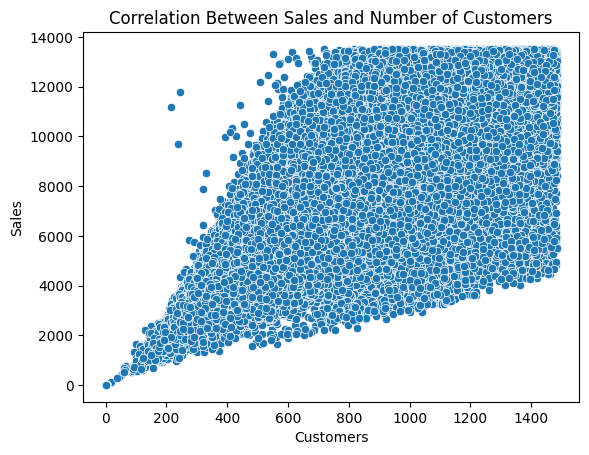

In [57]:
sns.scatterplot(x='Customers', y='Sales', data=train_store_data)
plt.title('Correlation Between Sales and Number of Customers')
plt.show()

In [58]:
train_store_data[['Customers','Sales']].corr()

,Customers,Sales
Customers,1.000000,0.911452
Sales,0.911452,1.000000


# Effect of Promos on Sales

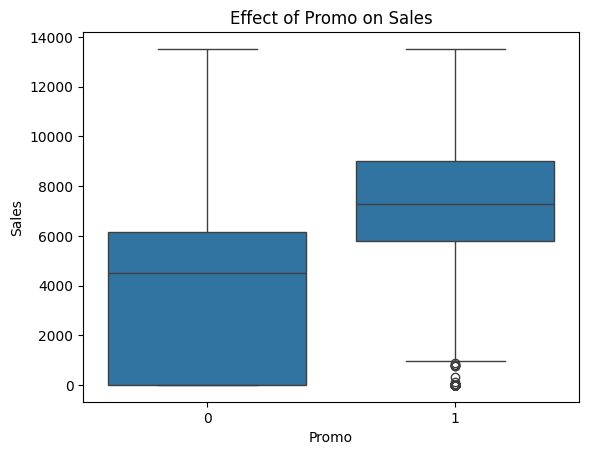

In [59]:
sns.boxplot(x='Promo', y='Sales', data=train_store_data)
plt.title('Effect of Promo on Sales')
plt.show()

In [60]:
train_store_data[['Promo','Sales']].corr()

,Promo,Sales
Promo,1.000000,0.478154
Sales,0.478154,1.000000


In [61]:
# Correlation between promo, Customers and sales
train_store_data[['Promo', 'Customers','Sales']].corr()

,Promo,Customers,Sales
Promo,1.000000,0.366715,0.478154
Customers,0.366715,1.000000,0.911452
Sales,0.478154,0.911452,1.000000


# Deployment of Promos in Stores

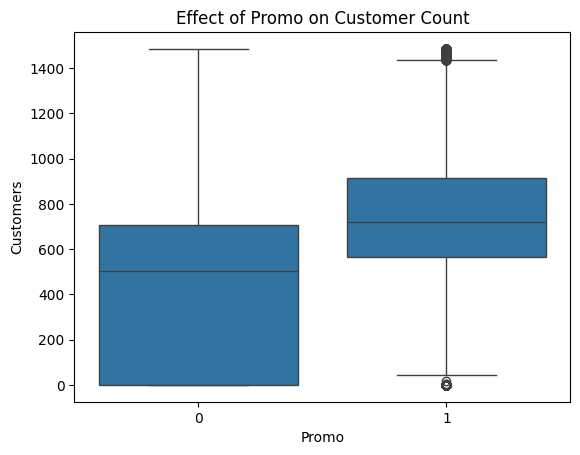

In [62]:
# Analyze the effect of promo on customers
sns.boxplot(x='Promo', y='Customers', data=train_store_data)
plt.title('Effect of Promo on Customer Count')
plt.show()

In [63]:
train_store_data[['Promo', 'Customers']].corr()

,Promo,Customers
Promo,1.000000,0.366715
Customers,0.366715,1.000000


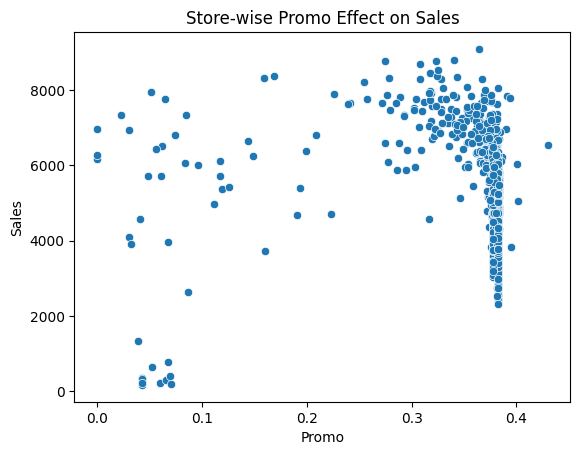

In [64]:
# Check store-wise promo effect
store_promo_effect = train_store_data.groupby('Store')[['Promo', 'Sales']].mean().reset_index()
sns.scatterplot(x='Promo', y='Sales', data=store_promo_effect)
plt.title('Store-wise Promo Effect on Sales')
plt.show()

# Customer Behavior During Store Open and Closing Times

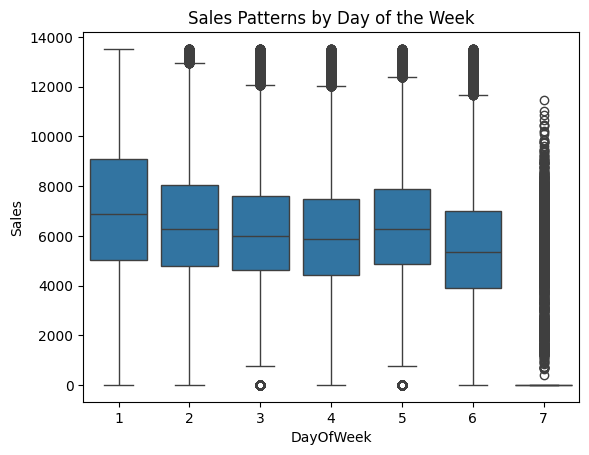

In [65]:
# Analyze sales patterns by day of the week
sns.boxplot(x='DayOfWeek', y='Sales', data=train_store_data)
plt.title('Sales Patterns by Day of the Week')
plt.show()

# Weekday Open Stores and Weekend Sales

In [66]:
# Identify stores that are open on all weekdays
weekday_data = train_store_data[train_store_data['DayOfWeek'].isin([1, 2, 3, 4, 5])]
weekday_open_stores = train_store_data.groupby('Store')['Open'].sum().reset_index()
weekday_open_stores = weekday_open_stores[weekday_open_stores == 5].index.tolist()

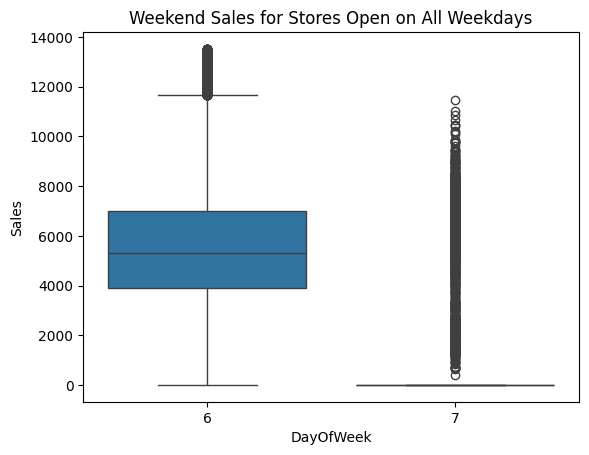

In [67]:
# Compare weekend sales for these stores
weekend_sales = train_store_data[(train_store_data['Store'].isin(weekday_open_stores)) & (train_store_data['DayOfWeek'] >= 6)]
sns.boxplot(x='DayOfWeek', y='Sales', data=weekend_sales)
plt.title('Weekend Sales for Stores Open on All Weekdays')
plt.show()

# Effect of Assortment Type on Sales

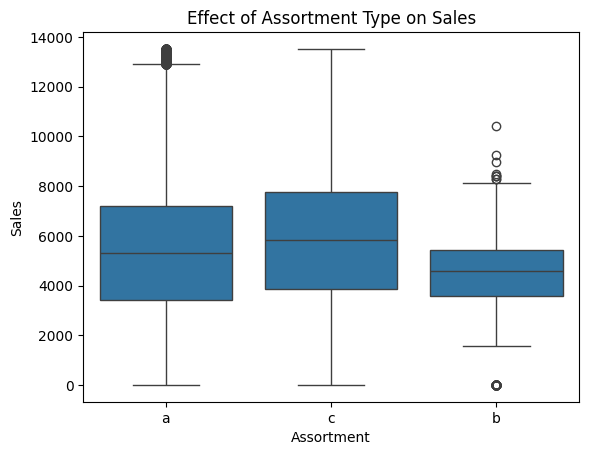

In [68]:
# Analyze the effect of assortment type on sales
sns.boxplot(x='Assortment', y='Sales', data=train_store_data)
plt.title('Effect of Assortment Type on Sales')
plt.show()

# Impact of Competitor Distance on Sales

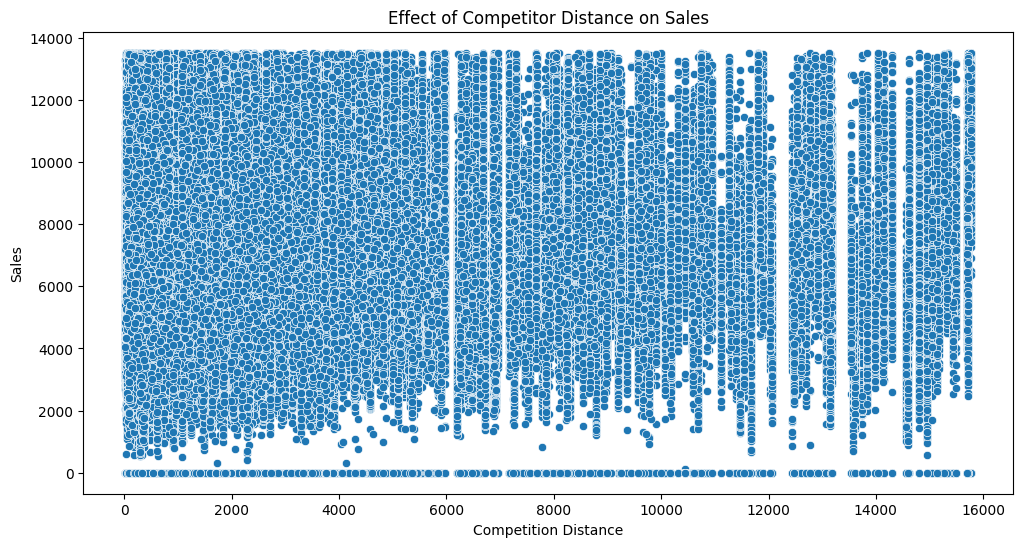

In [70]:
# Scatter plot of CompetitionDistance vs Sales
plt.figure(figsize=(12, 6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=train_store_data)
plt.title('Effect of Competitor Distance on Sales')
plt.xlabel('Competition Distance')
plt.ylabel('Sales')
plt.show()

In [71]:
# # Assume city center stores have a high density of competitors and a short distance
city_center_stores = train_store_data[train_store_data['CompetitionDistance'] < 1000]

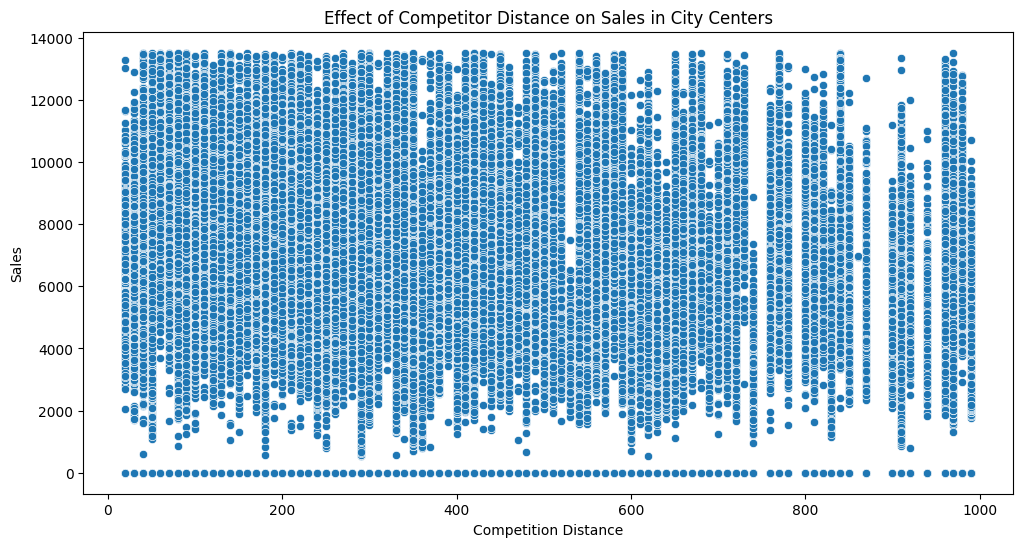

In [72]:
# Scatter plot for city center stores
plt.figure(figsize=(12, 6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=city_center_stores)
plt.title('Effect of Competitor Distance on Sales in City Centers')
plt.xlabel('Competition Distance')
plt.ylabel('Sales')
plt.show()

# Effect of New Competitors

In [73]:
# Identify stores with NA initially in CompetitionDistance and later values
initial_na_competition = train_store_data[train_store_data['CompetitionDistance'].isna()]
later_competition = train_store_data[train_store_data['CompetitionDistance'].notna()]

In [74]:
# Analyze the sales before and after the competition opens
initial_sales = initial_na_competition.groupby('Store')['Sales'].mean()
later_sales = later_competition.groupby('Store')['Sales'].mean()

In [75]:
sales_effect = later_sales - initial_sales
print(sales_effect)

Store
1      NaN
2      NaN
3      NaN
4      NaN
6      NaN
        ..
1111   NaN
1112   NaN
1113   NaN
1114   NaN
1115   NaN
Name: Sales, Length: 1005, dtype: float64


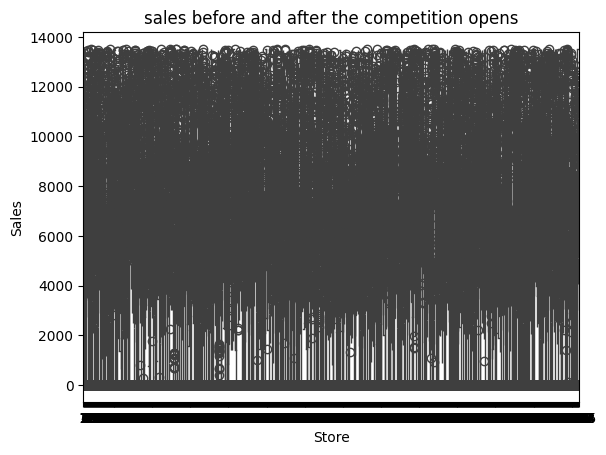

In [76]:
sns.boxplot(x='Store', y='Sales', data=train_store_data)
plt.title('sales before and after the competition opens')
plt.show()

# Findings

In [77]:
train_data.to_csv(r'C:\Users\DELL\Desktop\Next Hikes Documents\Project6\Data\cleaned_train_data.csv',index=False)
test_data.to_csv(r'C:\Users\DELL\Desktop\Next Hikes Documents\Project6\Data\cleaned_test_data.csv',index=False)
store_data.to_csv(r'C:\Users\DELL\Desktop\Next Hikes Documents\Project6\Data\cleaned_store_data.csv',index=False)